## The Main Code (two skills) for my Macro Paper
- Author: Junseok Lee (koileekr@snu.ac.kr)
- Last update: Apr 16, 2021
- Goal 1: model heterogeneous aggregate shocks
- Goal 2: find a mechanism that generates a large local mass around the reservation wages
- The belows are currenty preliminary results. (I only calculate the steady state.)

In [301]:
using Plots, NLsolve, Roots, Interpolations, Optim, Random, Images, Dierckx, CSV, DataFrames
using Parameters, QuantEcon, Distributions, StatsBase, Statistics, ProgressBars

### External Parameters

In [2]:
const α = 0.64 # labor share
const γ = 0.4 # intensive Frish elasticity
const hbar = 1/3 # hours worked
const amin = 0 # asset lower bound
const curv = 1.7 # asset grid curvature
const δ = 0.025 # depreciation ratio (quarterly)
const θ = 1.43 # constant elasticity btw skilled and unskilled (Katz and Murphy 1992)
const ne = 2 # number of skill grid
const ρx = 0.929 # persistence of labor productivity shocks (Chang and Kim 2006)
const σx = 0.227 # volatility of labor productivity shocks (Chang and Kim 2006)
const srate = 0.47; # population ratio of skilled (skilled / (unskilled + skilled), CPS 2019.Q4)

### Target Moments (CPS 2019.Q4)
- Skilled Employment Rate = 0.74 by `Bu` (disutility of the unskilled)
- Unkilled Employment Rate = 0.87 by `Bs` (disutility of the skilled)
- Wage Discount = 0.53 by `s` (skill demand)
- Interest rate = 0.01 by `β` (time discount rate)

In [3]:
Data_empu = 0.74 # unskilled employment rate
Data_emps = 0.87 # skilled employment rate
Data_wdis = 0.54 # wage discount
Data_rate = 1.00; # interate rate

1.0

In [38]:
function TV(VE::Array{Float64,3}, VN::Array{Float64,3},
        wu::Float64, ws::Float64, r::Float64, β::Float64,
        na::Int64, nz::Int64, Bu::Float64, Bs::Float64, amax::Float64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2};
        compute_policy=false)
    """
    Update Each Value Function by Optimzation
    Notation: E (Employment), N (Not Working)
    """
    TVE = zeros(ne,na,nz)
    TVN = zeros(ne,na,nz)
    
    if compute_policy
        AS = zeros(ne,na,nz)
        HR = zeros(ne,na,nz)
        CS = zeros(ne,na,nz)
    end

    for ie in 1:ne

        if ie == 1
            w = wu  # unskilled
            B = Bu * hbar ^ (1+1/γ) / (1+1/γ)
        else
            w = ws # skilled
            B = Bs * hbar ^ (1+1/γ) / (1+1/γ)
        end
        
        VE′s = [LinearInterpolation(agrid, VE[ie,:,iz]) for iz in 1:nz]
        VN′s = [LinearInterpolation(agrid, VN[ie,:,iz]) for iz in 1:nz]

        for (iz, ez) in enumerate(ezgrid)
            
            objE = (a′ -> log(w * ez * hbar + (1 + r) * a - a′ + eps()) - B
                + β * (sum([max(VE′(a′), VN′(a′)) for (VE′, VN′) in zip(VE′s, VN′s)], weights(Π[iz,:]))) for a in agrid)
            objN = (a′ -> log((1 + r) * a - a′+ eps())
                + β * (sum([max(VE′(a′), VN′(a′)) for (VE′, VN′) in zip(VE′s, VN′s)], weights(Π[iz,:]))) for a in agrid)

            resultsE = maximize.(objE, amin, min.((w * ez * hbar) .+ (1 + r) .* agrid, amax))
            resultsN = maximize.(objN, amin, min.((1 + r) .* agrid, amax))

            TVE[ie,:,iz] = Optim.maximum.(resultsE)
            TVN[ie,:,iz] = Optim.maximum.(resultsN)

            if compute_policy

                for (ia, a) in enumerate(agrid)

                    if TVE[ie,ia,iz] >= TVN[ie,ia,iz]
                        AS[ie,ia,iz] = Optim.maximizer(resultsE[ia])
                        HR[ie,ia,iz] = hbar
                        CS[ie,ia,iz] = w * ez * hbar + (1 + r) * a - AS[ie,ia,iz]
                    else
                        AS[ie,ia,iz] = Optim.maximizer(resultsN[ia])
                        HR[ie,ia,iz] = 0.0
                        CS[ie,ia,iz] = (1 + r) * a - AS[ie,ia,iz]
                    end
                end
            end
        end
    end
    if compute_policy
        return TVE, TVN, AS, HR, CS
    end
    return TVE, TVN
end

TV (generic function with 1 method)

In [66]:
function VFI(init_VE::Array{Float64,3}, init_VN::Array{Float64,3},
        wu::Float64, ws::Float64, r::Float64, β::Float64,
        na::Int64, nz::Int64, Bu::Float64, Bs::Float64, amax::Float64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2}, TV;
        max_iter = 1e10, tol = 1e-5)
    """
    Value Function Iteration
    """
    println("VFI")
    VE = init_VE
    VN = init_VN
    for iter in 0:max_iter
        TVE, TVN = TV(VE, VN, wu, ws, r, β, na, nz, Bu, Bs, amax, agrid, ezgrid, Π)
        diff = maximum(abs.(TVE .- VE)) + maximum(abs.(TVN .- VN))
        if diff < tol
            return TVE, TVN
        else
            if iter % 500 == 0
                println(diff)
            end
            VE = TVE
            VN = TVN
        end
    end
    println("Not Converged!")
end;

In [67]:
function Tμ(μ::Array{Float64,3}, AS::Array{Float64,3}, na::Int64, nz::Int64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2})
    """
    Update Each Discretized PDF(μ)
    """
    μ′ = zeros(ne,na,nz)
    for ie in 1:ne
        for iz in 1:nz
            for ia in 1:na
                ia′h = findfirst(a′-> a′ > AS[ie,ia,iz], agrid)
                if ia′h == nothing
                    μ′[ie,end,:] .+= μ[ie,ia,iz] .* Π[iz,:]
                else
                    ia′l = ia′h - 1
                    wgt = (agrid[ia′h]-AS[ie,ia,iz]) / (agrid[ia′h]-agrid[ia′l])
                    μ′[ie,ia′l,:] .+= μ[ie,ia,iz] .* Π[iz,:] * wgt
                    μ′[ie,ia′h,:] .+= μ[ie,ia,iz] .* Π[iz,:] * (1-wgt)
                end
            end
        end
    end
    return μ′
end;

In [68]:
function μFI(init_μ::Array{Float64,3}, AS::Array{Float64,3}, na::Int64, nz::Int64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2}, Tμ;
        max_iter=10e10, tol=1e-6)
    """
    PDF(μ) Iteration
    """
    println("μFI")
    μ = init_μ
    for iter in 1:max_iter
        μ′ = Tμ(μ, AS, na, nz, agrid, ezgrid, Π)
        diff = maximum(abs.(μ′ .- μ))
        if diff < tol
            return μ′
        else
            if iter % 1000 == 0
                println(diff)
            end
            μ = μ′
        end
    end
    println("Not Converged!")
end;

In [69]:
function findLK(init_VE::Array{Float64,3}, init_VN::Array{Float64,3},
        init_μ::Array{Float64,3}, Lu::Float64, Ls::Float64, K::Float64,
        β::Float64, s::Float64, na::Int64, nz::Int64,
        Bu::Float64, Bs::Float64, amax::Float64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2},
        TV, VFI, Tμ, μFI)
    """
    Find Aggregate Labor and Capital given τ using a Shooting Algorithm 
    """
    println("finkLK")
    L = (s * Lu ^ ((θ-1)/θ) + (1-s) * Ls ^ ((θ-1)/θ)) ^ (θ/(θ-1))
    wu = α * (K/L) ^ (1-α) * s * (L/Lu) ^ (1/θ)
    ws = α * (K/L) ^ (1-α) * (1-s) * (L/Ls) ^ (1/θ)
    rmax = 1 / β - 1 - eps()
    rmin = - δ + eps()
    r = min(max((1 - α) * (L / K) ^ α - δ, rmin), rmax)
    
    VE, VN = VFI(init_VE, init_VN, wu, ws, r, β, na, nz,
        Bu, Bs, amax, agrid, ezgrid, Π, TV)
    VE, VN, AS, HR, CS = TV(VE, VN, wu, ws, r, β, na, nz,
        Bu, Bs, amax, agrid, ezgrid, Π; compute_policy=true)
    μ = μFI(init_μ, AS, na, nz, agrid, ezgrid, Π, Tμ)
    
    Lu′ = sum([ez * sum(μ[1,:,iz] .* HR[1,:,iz]) for (iz, ez) in enumerate(ezgrid)])
    Ls′ = sum([ez * sum(μ[2,:,iz] .* HR[2,:,iz]) for (iz, ez) in enumerate(ezgrid)])
    K′ = sum([sum(μ[:,ia,:] .* a) for (ia, a) in enumerate(agrid)])
    
    L′ = (s * Lu′ ^ ((θ-1)/θ) + (1-s) * Ls′ ^ ((θ-1)/θ)) ^ (θ/(θ-1))
    Kd = fzero(K′ -> (1 - α) * (L′/K′) ^ α - r - δ, 1)
    println(K′)
    println(Kd)
    return VE, VN, AS, HR, CS, μ, Lu′, Ls′, K′, Kd
end;

In [91]:
function SteadyState(init_VE::Array{Float64,3}, init_VN::Array{Float64,3},
        init_μ::Array{Float64,3}, init_Lu::Float64, init_Ls::Float64, init_K::Float64,
        β::Float64, s::Float64, na::Int64, nz::Int64, Bu::Float64, Bs::Float64, amax::Float64,
        agrid::Array{Float64,1}, ezgrid::Array{Float64,1}, Π::Array{Float64,2},
        TV, VFI, Tμ, μFI, findLK;
        max_iter=1e10, tol=0.001,
        convex_combi::Float64=0.05, shrink_factor::Float64=0.5,
        expand_factor::Float64=1.1, damp_min::Float64=0.02)
    """
    Find Aggregate Labor and Capital given τ using a Shooting Algorithm
    """
    VE = init_VE
    VN = init_VN
    μ = init_μ
    Lu = init_Lu
    Ls = init_Ls
    K = init_K
    damp = convex_combi
    diff = Inf
    
    for iter in 1:max_iter
        println("Lu = $(round(Lu, digits=16))")
        println("Ls = $(round(Ls, digits=16))")
        println("K  = $(round(K, digits=16))")
        println("------------------------------------------------------")
        VE, VN, AS, HR, CS, μ, Lu′, Ls′, K′, Kd = findLK(
            VE, VN, μ, Lu, Ls, K, β, s, na, nz, Bu, Bs,
            amax, agrid, ezgrid, Π, TV, VFI, Tμ, μFI)
        
        diff′ = abs(Lu′ - Lu) / Lu + abs(Ls′ - Ls) / Ls + abs(K′ - K) / K + abs(Kd - K) / K
        
        if diff′ < tol
            return VE, VN, AS, HR, CS, μ, Lu′, Ls′, K′
        else
            # Adjust a dampening factor
            if diff′ > diff
                damp = max(damp * shrink_factor, damp_min)
            else
                damp = min(damp * expand_factor, 0.97)
            end
            
            Lu = Lu * (1.0 - damp) + Lu′ * damp
            Ls = Ls * (1.0 - damp) + Ls′ * damp
            K = K * (1.0 - damp) + (K′+ Kd) / 2 * damp
            
            L = (s * Lu ^ ((θ-1)/θ) + (1-s) * Ls ^ ((θ-1)/θ)) ^ (θ/(θ-1))
            wu = α * (K/L) ^ (1-α) * s * (L/Lu) ^ (1/θ)
            ws = α * (K/L) ^ (1-α) * (1-s) * (L/Ls) ^ (1/θ)

            empu = sum(μ[1,:,:] .* (HR[1,:,:] .> 0)) / sum(μ[1,:,:])
            emps = sum(μ[2,:,:] .* (HR[2,:,:] .> 0)) / sum(μ[2,:,:])
            wdis = wu / ws
            rate = (1 - α) * (L / K) ^ α - δ
            
            println("------------------------------------------------------")
            println("dampening factor: $(round(damp, digits=8))")
            println("current difference: $(round(diff′, digits=8))")
            println("current empu: $(round(empu, digits=8))")
            println("current emps: $(round(emps, digits=8))")
            println("current wdis: $(round(wdis, digits=8))")
            println("current rate: $(round(rate*100, digits=8))")
            println("------------------------------------------------------")
            
        end
        diff = diff′
    end
end;

In [153]:
# from CES production function 
s = 0.35 # match skill wage gap wu / ws = 0.54
β = 0.98898; # irate = 1.00%
Bu = 156.9 # unskilled emp rate = 0.74
Bs = 138.3 # skilled = emp rate 0.87

# Asset
amax = 25.0;
na = 51 # number of asset grids
agrid = [amin + amax * ((ia-1)/(na-1)) ^ curv for ia in 1:na];

# Productivity
nz = 31 # number of labor prod shocks
ezgrid = exp.(range(-3 * σx, 3 * σx, length = nz));
mc = tauchen(nz, ρx, σx * sqrt(1 - ρx ^ 2), 0);
Π = mc.p;
SSprob = stationary_distributions(mc)[1];

In [138]:
init_VE = zeros(ne,na,nz)
init_VN = zeros(ne,na,nz)
init_μ = zeros(ne,na,nz)
init_μ[1,:,:] = repeat(transpose(SSprob), na) / na * (1-srate)
init_μ[2,:,:] = repeat(transpose(SSprob), na) / na * srate

init_Lu = 0.1409101222108031
init_Ls = 0.141673157401118
init_K  = 5.411284361893749

5.411284361893749

In [154]:
init_VE = VE
init_VN = VN
init_μ = μ

init_Lu = Lu
init_Ls = Ls
init_K  = K;

In [155]:
@time VE, VN, AS, HR, CS, μ, Lu, Ls, K = SteadyState(
    init_VE, init_VN, init_μ, init_Lu, init_Ls, init_K,
    β, s, na, nz, Bu, Bs, amax, agrid, ezgrid, Π, TV,
    VFI, Tμ, μFI, findLK; tol = 0.01, convex_combi=0.05);

Lu = 0.1417330922169525
Ls = 0.1421907492105933
K  = 5.381999680410148
------------------------------------------------------
finkLK
VFI
0.01259947738053313
μFI
5.638487420193157
5.350857418924412
------------------------------------------------------
dampening factor: 0.055
current difference: 0.06678603
current empu: 0.72374312
current emps: 0.84564903
current wdis: 0.53979957
current rate: 1.01248443
------------------------------------------------------
Lu = 0.1416580462824822
Ls = 0.142161688118846
K  = 5.388196681063323
------------------------------------------------------
finkLK
VFI
0.004221345026195422
μFI
5.645869321880586
5.357196335100087
------------------------------------------------------
dampening factor: 0.0275
current difference: 0.06680437
current empu: 0.72341359
current emps: 0.84540376
current wdis: 0.53985928
current rate: 1.01082933
------------------------------------------------------
Lu = 0.1416210781119274
Ls = 0.1421470684579471
K  = 5.391313425117566
----

In [156]:
L = (s * Lu ^ ((θ-1)/θ) + (1-s) * Ls ^ ((θ-1)/θ)) ^ (θ/(θ-1))
wu = α * (K/L) ^ (1-α) * s * (L/Lu) ^ (1/θ)
ws = α * (K/L) ^ (1-α) * (1-s) * (L/Ls) ^ (1/θ)

Model_empu = sum(μ[1,:,:] .* (HR[1,:,:] .> 0)) / sum(μ[1,:,:])
Model_emps = sum(μ[2,:,:] .* (HR[2,:,:] .> 0)) / sum(μ[2,:,:])
Model_wdis = wu/ws
Model_rate = (1 - α) * (L / K) ^ α - δ;

### Check the Distribution of the unskilled

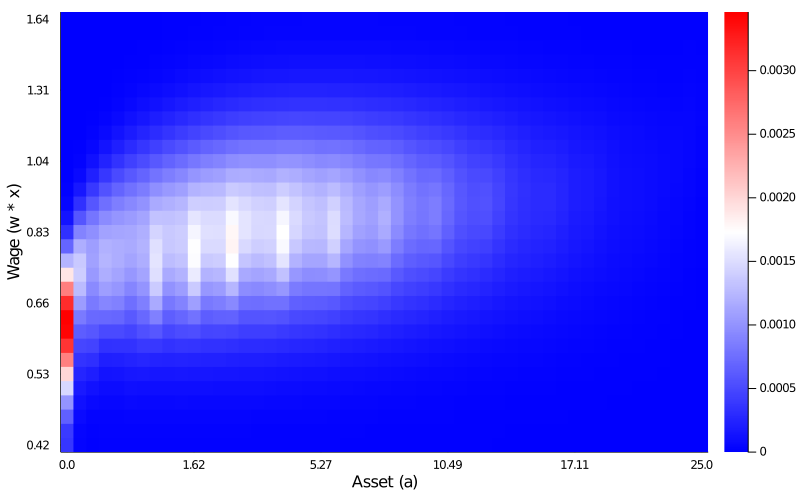

In [157]:
heatmap(transpose(μ[1,:,:]), c=cgrad([:blue, :white, :red]), xlabel = "Asset (a)", ylabel = "Wage (w * x)",
    yticks=(1:5:nz, round.(wu .* ezgrid[1:5:nz], digits=2)),
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), size=(na*7.85*2,nz*8*2))

### Check the Distribution of the Skilled

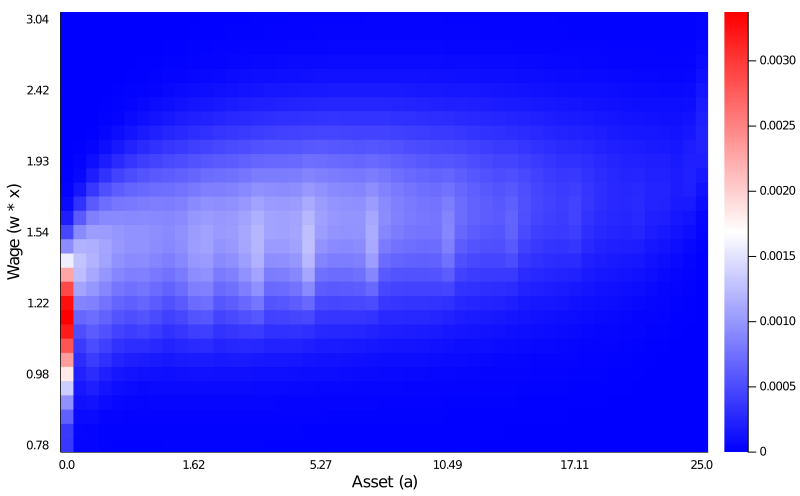

In [158]:
heatmap(transpose(μ[2,:,:]), c=cgrad([:blue, :white, :red]), xlabel = "Asset (a)", ylabel = "Wage (w * x)",
    yticks=(1:5:nz, round.(ws .* ezgrid[1:5:nz], digits=2)),
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), size=(na*7.85*2,nz*8*2))

### Check the Results of Calibration

In [320]:
println("==================[Data VS Model]===================")
println("Emp of Unskilled   : (Model) $(round(Model_empu, digits=2))   VS   (Data) $Data_empu")
println("Emp of Skilled     : (Model) $(round(Model_emps, digits=2))   VS   (Data) $Data_emps")
println("Wage Discount      : (Model) $(round(Model_wdis, digits=2))   VS   (Data) $Data_wdis")
println("Interate Rate      : (Model) $(round(Model_rate*100, digits=2))   VS   (Data) $Data_rate")

==================[Data VS Model]===================
Emp of Unskilled   : (Model) 0.73   VS   (Data) 0.74
Emp of Skilled     : (Model) 0.85   VS   (Data) 0.87
Wage Discount      : (Model) 0.54   VS   (Data) 0.54
Interate Rate      : (Model) 1.02   VS   (Data) 1.0


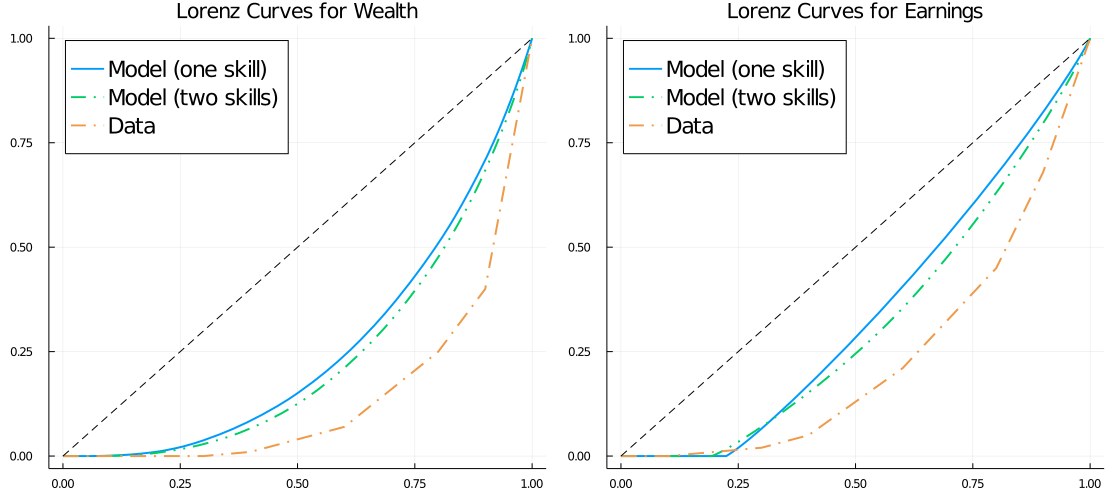

In [313]:
Data_Lorenza = [0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.07, 0.16, 0.25, 0.4, 1.0];
Data_Lorenze = [0.0, 0.0, 0.01, 0.02, 0.05, 0.13, 0.21, 0.33, 0.45, 0.68, 1.0];

lorenz_one = CSV.read("./lorenz_one.csv");
wlth_one = lorenz_one[:,1]
earn_one = lorenz_one[:,2]


smpu = [sample(1:na, weights(μ[1,:,iz]./sum(μ[1,:,iz])), floor(Int32, SSprob[iz]*1000)) for iz in 1:nz]
smps = [sample(1:na, weights(μ[2,:,iz]./sum(μ[2,:,iz])), floor(Int32, SSprob[iz]*1000)) for iz in 1:nz]
wlthu = [agrid[ia] for smp in smpu for ia in smp]
wlths = [agrid[ia] for smp in smps for ia in smp]
earnu = [wu * ezgrid[iz] * HR[1,ia,iz] for (iz, smp) in enumerate(smpu) for ia in smp]
earns = [ws * ezgrid[iz] * HR[2,ia,iz] for (iz, smp) in enumerate(smps) for ia in smp]
wlth = sort(append!(wlthu, wlths))
earn = sort(append!(earnu, earns));

l = @layout [a b]
p1 = plot(range(0,1,length=length(wlth_one)), cumsum(wlth_one)./sum(wlth_one), label="Model (one skill)", lw=2)
plot!(p1, range(0.0,1.0,length=length(wlth)), cumsum(wlth) ./ sum(wlth), label="Model (two skills)", linestyle=:dashdotdot,
    legend=:topleft, legendfontsize=15, lw=2, title="Lorenz Curves for Wealth", color="springgreen3")
plot!(p1, 0.0:0.1:1.0, Data_Lorenza, linestyle=:dashdot, label="Data", lw=2, color=:tan2)

plot!(p1, 0:0.1:1, 0:0.1:1, color=:black, lw=1, label="", linestyle=:dash)
p2 = plot(range(0,1,length=length(earn_one)), cumsum(earn_one)./sum(earn_one), label="Model (one skill)", lw=2)
plot!(range(0.0,1.0,length=length(earn)), cumsum(earn) ./ sum(earn), color="springgreen3", label="Model (two skills)",
    legend=:topleft, legendfontsize=15, lw=2, title="Lorenz Curves for Earnings", linestyle=:dashdotdot)
plot!(p2, 0.0:0.1:1.0, Data_Lorenze, linestyle=:dashdot, label="Data", lw=2, color=:tan2)
plot!(p2, 0:0.1:1, 0:0.1:1, color=:black, lw=1, label="", linestyle=:dash)
plot(p1, p2, size=(nz*18*2,nz*8*2), fmt=:png)

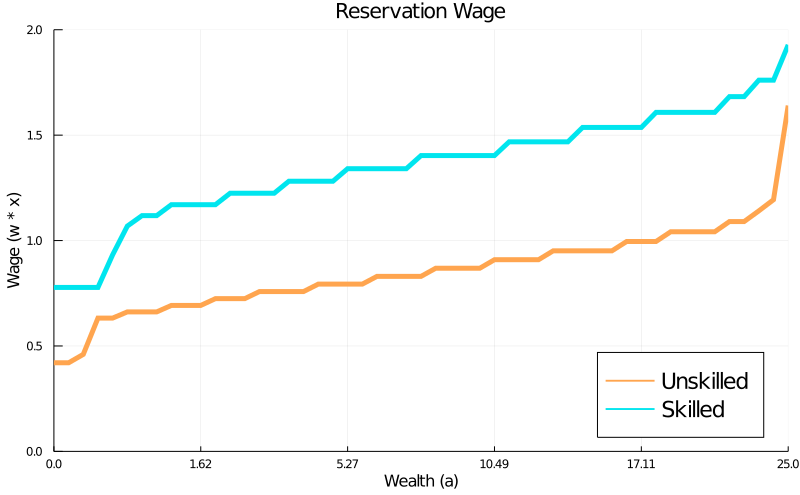

In [277]:
# reservation wage
rw = zeros(Int64, ne,na);
tmprw = [findfirst(x->x>0, transpose(HR[1,:,:])[:,ia]) for ia in 1:na];
tmprw[findall(x->x==nothing, tmprw)] .= nz
rw[1,:] .= tmprw

plot(1:na, wu .* ezgrid[rw[1,:]], color=:tan1, lw=5, label="Unskilled",
    legend=:bottomright, legendfontsize=15, ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png,xlabel="Wealth (a)",
    ylim=(0,2), xlim=(1,na), title = "Reservation Wage", size=(na*7.85*2,nz*8*2))

tmprw = [findfirst(x->x>0, transpose(HR[2,:,:])[:,ia]) for ia in 1:na];
tmprw[findall(x->x==nothing, tmprw)] .= nz
rw[2,:] .= tmprw

plot!(1:na, ws .* ezgrid[rw[2,:]], color=:turquoise2, lw=5, label="Skilled",
    legend=:bottomright, legendfontsize=15, ylabel="Wage (w * x)",
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), fmt=:png, xlabel="Wealth (a)") 

In [210]:
# reservation raise
RR = zeros(ne,na,nz);
for ie in 1:ne
    for ia in 1:na
        for iz in 1:nz
            RR[ie,ia,iz] = (ezgrid[rw[ie,ia]]-ezgrid[iz]) / ezgrid[iz]
        end
    end
end

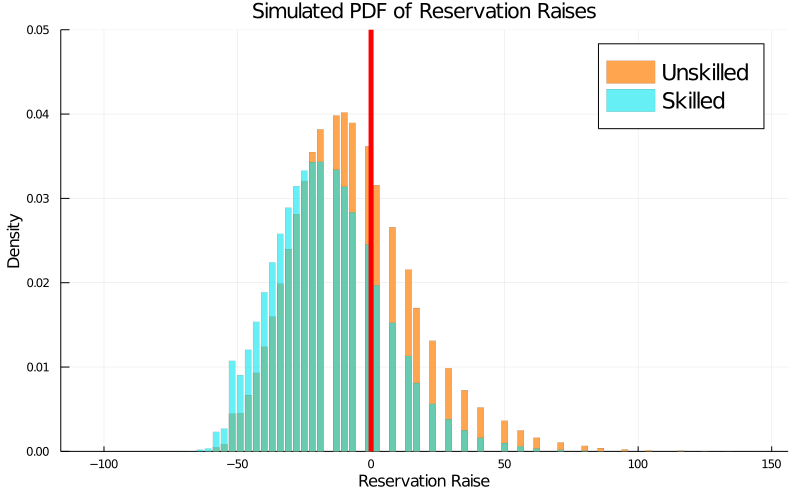

In [274]:
lbd = -1.0
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[1,findall(rr->x<=rr<x+s, RR[1,:,:])]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, RRdist)
bar(rrgrid, RRdist, xlabel="Reservation Raise", ylabel="Density", size=(na*7.85*2,nz*8*2),
    ylim=(0,0.05), label="Unskilled", color="tan1", lw=0.1, title="Simulated PDF of Reservation Raises", fmt=:png, legendfontsize=15)
RRdist = [sum(μ[2,findall(rr->x<=rr<x+s, RR[2,:,:])]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, RRdist)
bar!(rrgrid, RRdist, xlabel="Reservation Raise", ylabel="Density",
    ylim=(0,0.05), label="Skilled", color="turquoise2", lw=0.1, title="Simulated PDF of Reservation Raises", fmt=:png, alpha=0.6)
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=5)

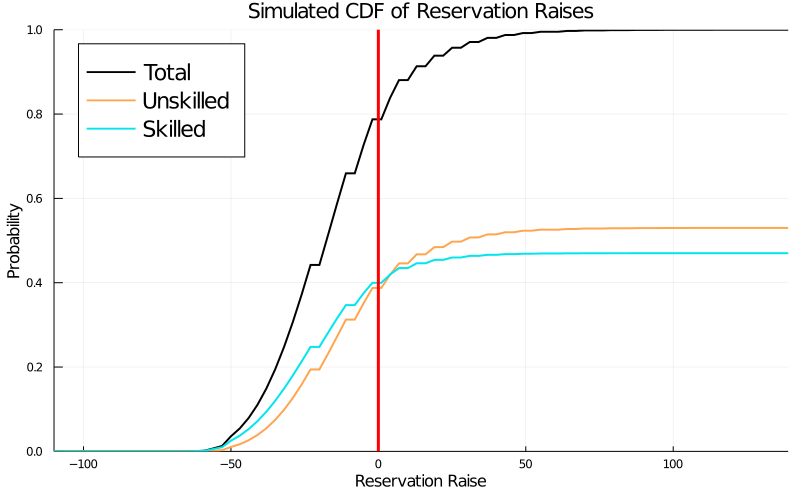

In [275]:
lbd = -1.1
ubd = 1.4
s=0.03
rrgrid = 100 .*(lbd:s:ubd)
rrgrid2 = 100 .*(lbd:0.025*s:0.0)
RRdist = [sum(μ[findall(rr->x<=rr<x+s, RR)]) for x in lbd:s:ubd]
RRfunc = LinearInterpolation(rrgrid, cumsum(RRdist))
plot(rrgrid, cumsum(RRdist), xlabel="Reservation Raise", ylabel="Probability",
    legendfontsize=15, legend=:topleft, size=(na*7.85*2,nz*8*2),
    ylim=(0,1.0), label="Total", color="black", lw=2, title="Simulated CDF of Reservation Raises",
    fmt=:png, xlim=(rrgrid[1], rrgrid[end]))
RRdistu = [sum(μ[1,findall(rr->x<=rr<x+s, RR[1,:,:])]) for x in lbd:s:ubd]
RRfuncu = LinearInterpolation(rrgrid, cumsum(RRdistu))
plot!(rrgrid, cumsum(RRdistu), xlabel="Reservation Raise", ylabel="Probability",
    ylim=(0,1.0), label="Unskilled", color="tan1", lw=2, title="Simulated CDF of Reservation Raises",
    fmt=:png, xlim=(rrgrid[1], rrgrid[end]))
RRdists = [sum(μ[2,findall(rr->x<=rr<x+s, RR[2,:,:])]) for x in lbd:s:ubd]
RRfuncs = LinearInterpolation(rrgrid, cumsum(RRdists))
plot!(rrgrid, cumsum(RRdists), xlabel="Reservation Raise", ylabel="Probability",
    ylim=(0,1.0), label="Skilled", color="turquoise2", lw=2, title="Simulated CDF of Reservation Raises",
    fmt=:png, xlim=(rrgrid[1], rrgrid[end]))
plot!([0.0,0.0],[0.0,1.0], label="", color="red", lw=3)

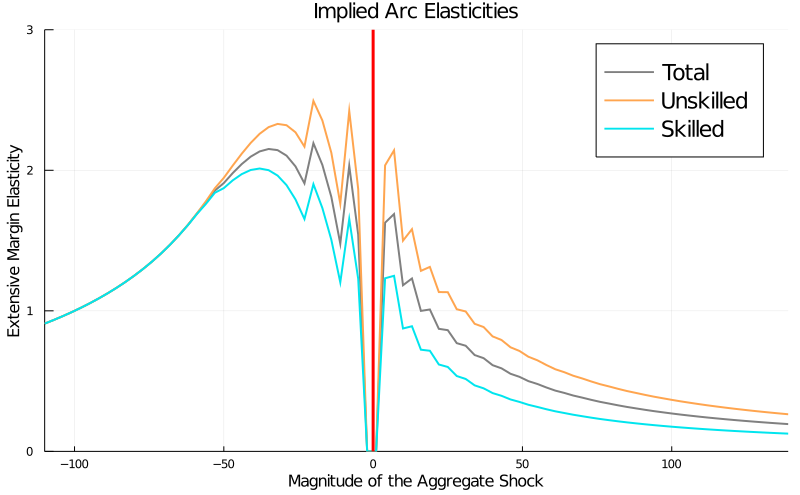

In [276]:
arc = 100 .* ((cumsum(RRdist) .- RRfunc(0.0)) ./ RRfunc(0.0)) ./ rrgrid
arcu = 100 .* ((cumsum(RRdistu) .- RRfuncu(0.0)) ./ RRfuncu(0.0)) ./ rrgrid
arcs = 100 .* ((cumsum(RRdists) .- RRfuncs(0.0)) ./ RRfuncs(0.0)) ./ rrgrid
#arca = arcu .* (1-srate) + arcs .* srate
plot(rrgrid, arc, color=:gray, lw=2, title = "Implied Arc Elasticities",
    ylabel="Extensive Margin Elasticity", legend=:topright, legendfontsize=15,
    label="Total", ylim=(0,3), xlim=(rrgrid[1], rrgrid[end]), size=(na*7.85*2,nz*8*2),
    xlabel="Magnitude of the Aggregate Shock", fmt=:png)
plot!(rrgrid, arcu, color=:tan1, lw=2, title = "Implied Arc Elasticities",
    ylabel="Extensive Margin Elasticity", label="Unskilled", ylim=(0,3), xlim=(rrgrid[1], rrgrid[end]),
    xlabel="Magnitude of the Aggregate Shock", fmt=:png)
plot!(rrgrid, arcs, color=:turquoise2, lw=2, title = "Implied Arc Elasticities",
    ylabel="Extensive Margin Elasticity", label="Skilled", ylim=(0,3), xlim=(rrgrid[1], rrgrid[end]),
    xlabel="Magnitude of the Aggregate Shock", fmt=:png)
#plot!(rrgrid, arca, label="Avg", color=:maroon1, lw=2)
plot!([0.0,0.0],[0.0,4.0], label="", color="red", lw=3)